In [145]:
from trend_cycle_inflation import ARTrendCycle
#from trend_cycle_inflation import LocalLinearTrend
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
cpi_source = pd.read_excel("CPALTT01USQ661S.xlsx", sheet_name="Quarterly", index_col="observation_date")


In [261]:
cpi = cpi_source 
cpi = np.log(cpi).diff(1)
cpi = cpi[4:]
cpi = cpi.rolling(4).mean()
cpi = cpi[3:]
cpi.describe()

,CPALTT01USQ661S
count,274.000000
mean,0.008973
std,0.006499
min,-0.004050
25%,0.004517
50%,0.007469
75%,0.010930
max,0.033689


In [262]:
cpi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 1956-10-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CPALTT01USQ661S  274 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


<AxesSubplot:xlabel='observation_date'>

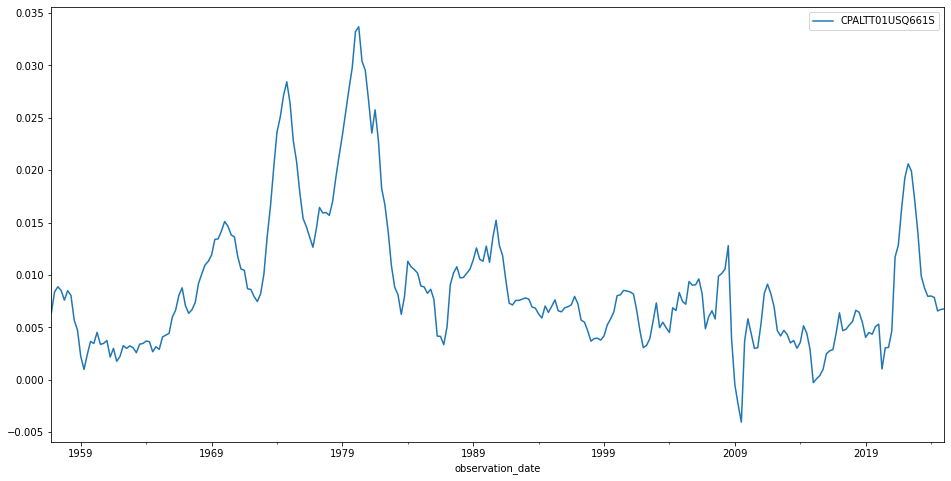

In [263]:
cpi.plot(figsize=(16,8))

In [264]:
model = ARTrendCycle(cpi)
res = model.fit()
res.summary()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        CPALTT01USQ661S   No. Observations:                  274
Model:                   ARTrendCycle   Log Likelihood                 532.585
Date:                Tue, 10 Jun 2025   AIC                          -1051.171
Time:                        21:08:10   BIC                          -1025.879
Sample:                    10-01-1956   HQIC                         -1041.019
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
trend_intercept     0.0195      0.058      0.339      0.735      -0.093       0.132
rho.trend           0.1999      0.279      0.716      0.474      -0.347       0.747
rho.cycle          -0.1960      0.176     -1.114      0.265      -0.541       0.149
trend_error         0.0095      0.007      1.450      0.147      -0.003       0.022
cycle.error        -0.0043      0.006     -0.713      0.476      -0.016       0.008
===================================================================================
Ljung-Box (L1) (Q):                  14.20   Jarque-Bera (JB):                76.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.86
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

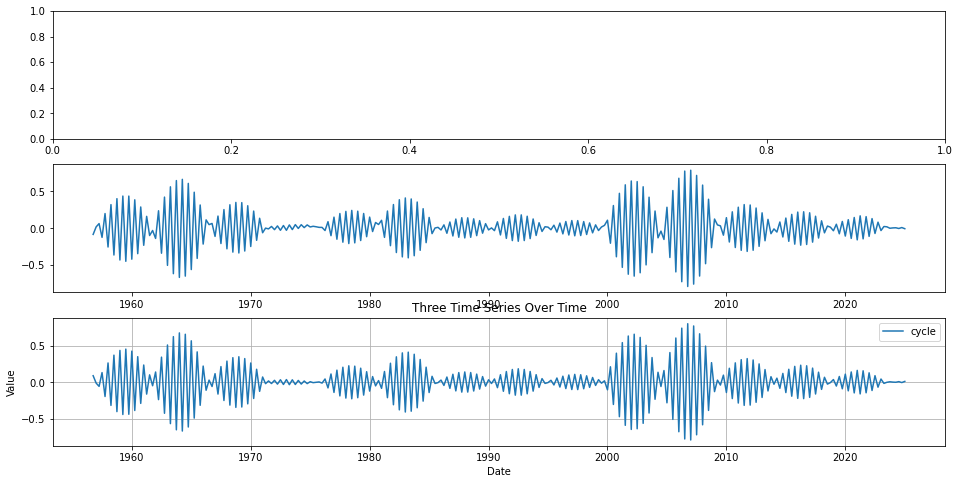

In [268]:
# Now plotting
fig, ax = plt.subplots(3,figsize=(16, 8)) # Adjust the figure size for Jupyter Notebook

ax[1].plot(cpi.index, res.smoothed_state[0], label='trend')
ax[2].plot(cpi.index, res.smoothed_state[1], label='cycle')

# Add labels, legend, title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Three Time Series Over Time')
plt.legend()
plt.grid(True)

""" # Improve x-axis date formatting
plt.xticks(rotation=45)
plt.tight_layout() """

plt.show()


In [249]:
import statsmodels.api as sm

class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog,
            k_states=k_states,
            k_posdef=k_posdef,
            initialization="approximate_diffuse",
            loglikelihood_burn=k_states,
        )

        # Initialize the matrices
        self.ssm["design"] = np.array([1, 0])
        self.ssm["transition"] = np.array([[1, 1], [0, 1]])
        self.ssm["selection"] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ("state_cov",) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ["sigma2.measurement", "sigma2.level", "sigma2.trend"]

    @property
    def start_params(self):
        return [np.std(self.endog)] * 3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm["obs_cov", 0, 0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [258]:
# Setup the model
mod = LocalLinearTrend(cpi)

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                           Statespace Model Results                           
Dep. Variable:        CPALTT01USQ661S   No. Observations:                  274
Model:               LocalLinearTrend   Log Likelihood                1336.167
Date:                Tue, 10 Jun 2025   AIC                          -2666.335
Time:                        21:04:00   BIC                          -2655.517
Sample:                    10-01-1956   HQIC                         -2661.992
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  1.136e-11   1.41e-07   8.05e-05      1.000   -2.77e-07    2.77e-07
sigma2.level        3.112e-06   3.14e-07      9.912      0.000     2.5e-06    3.73e-06
sigma2.trend        

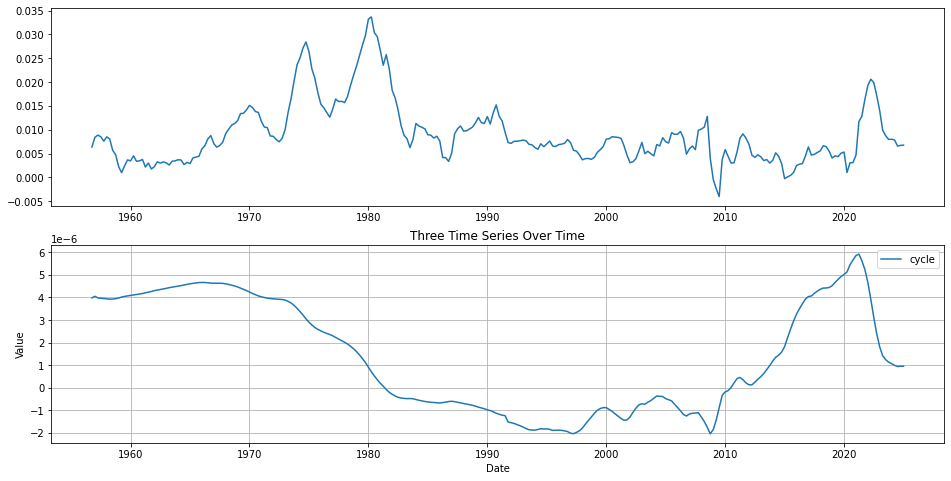

In [260]:
# Now plotting
fig, ax = plt.subplots(2,figsize=(16, 8)) # Adjust the figure size for Jupyter Notebook


ax[0].plot(cpi.index, res.smoothed_state[0], label='trend')
ax[1].plot(cpi.index, res.smoothed_state[1], label='cycle')


#ax2 = ax1.twinx()
#ax2.plot(cpi.index, cpi, label='CPI', color='green')

# Add labels, legend, title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Three Time Series Over Time')
plt.legend()
plt.grid(True)

""" # Improve x-axis date formatting
plt.xticks(rotation=45)
plt.tight_layout() """

plt.show()

In [252]:
f = res.forecast(40)
f.sum() / 10

20.26581703975662